In [1]:
# set backend
%matplotlib widget

In [2]:
#imports
import sqlite3 as sql
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

import ipyleaflet as leaf
import ipywidgets as ipyw
import json
from IPython.display import display_html
from itertools import chain,cycle

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world.continent == 'Europe']

/var/folders/mv/g7t2t7zs6zjdv1hksbybwd500000gn/T/ipykernel_77911/296129739.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [4]:
# Map without russia / cleaning

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe1 = world[world.continent == 'Europe']

# Create a new GeoDataFrame without Russia
europe = europe1[europe['name'] != 'Russia']

# Plot the map of Europe without Russia
#europe.plot()

#plt.title('Europe without Russia')
#plt.show()

# create new polygon from my undertasnig Im cropping the image above
#makes box

polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)]) # box shape co-ordinates

# Makes new geo dataframe ,with 1 row and a geometry column,crs = co-ordinate refrence systerm set to the world
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

#fig,ax=plt.subplots()
#ax=europe.plot(ax=ax) # plots countries on europe from the custom polygon
#poly_gdf.plot(edgecolor='red',ax=ax, alpha=0.1)

#plt.show()



/var/folders/mv/g7t2t7zs6zjdv1hksbybwd500000gn/T/ipykernel_77911/551007963.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [5]:
#Clip polygon from the map of Europe
europe=gpd.clip(europe, polygon)
#europe.plot()

In [6]:
# Read dataframe
conn1 = sql.connect(("data_combined_all.db"))
cur1 = conn1.cursor()

query = 'SELECT * FROM sheet_1'
every = pd.read_sql(query,conn1)

# print(country)
country =every.TIME
# print(country)
# x=len(country)
# print(x)

conn1.commit()
conn1.close()

In [7]:
# Let's skip the rows we don't want
reduced_db = every.iloc[3:]
#reduced_db

In [8]:
# reduce geojson data to countries we have data for
euro2 = europe[europe['name'].isin(reduced_db['TIME'])]
#euro2

In [9]:
def when_clicked_print_country_name(**args):
    print(args['properties']['name'])

In [10]:
# map for europe
euro = leaf.Map(center = (50.6252978589571, 0.34580993652344),
             zoom = 3,
             layout=ipyw.Layout(width='50%', height='350px',lenght='350px'))

geo_data = leaf.GeoData(geo_dataframe=euro2,
                   style={'color': 'white', 'fillColor': 'blue', 'opacity':0.6, 'weight':4.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

geo_data.on_click(when_clicked_print_country_name)

euro.add_layer(geo_data)

#euro

In [11]:
#  Graph 1 this can change for whatever graph
# Clean Generate graph of fatalites for a country

def sanatize_input(a):
    chars_to_remove = [';', '-', '.', '"'] #charachter to remove
    a = a.translate({ord(x): '' for x in chars_to_remove})
    a = a.strip()  #strip leading zeros
#     print(a)
    return a

def generate_total_fatal(country):

    conn = sql.connect("data_combined_all.db")
    cur = conn.cursor()
    #Sanatize user input before the graph is generated
    santize_country=sanatize_input(country)

    # Using parameterized query to avoid SQL injection for years and number
    query = "SELECT * FROM Sheet_1 WHERE Time = ?"
    data = pd.read_sql_query(query, conn, params=(country,))

    query2 = "SELECT * FROM GDP WHERE CountryName = ?"
    data2 = pd.read_sql_query(query2, conn, params=(country,))

    # Extracting and converting data for plotting
    years = data.columns[1:].astype(int)
    numbers = np.array(data.T)[1:].astype(int)

    gdp = np.array(data2.T[46:])

    # Close the database connection
    conn.close()

    return years, numbers, gdp



In [12]:
# doesn't automatically display, and where everything we want to change has a name (not neede for final below)

with plt.ioff():

    fig_data = plt.figure(figsize=(5,5))
    ax_data = fig_data.add_subplot(1, 1, 1)
    ax2 = ax_data.twinx()

    # the string variable 'constit' is used to select the constituency
    country = 'France'
    years, numbers,gdp = generate_total_fatal(country)


    fatalities_line, = ax_data.plot(years, numbers, label='Fatalities', linewidth = 2, color='blue')
    fatalities_line2, = ax2.plot(years, gdp, label='GDP', linewidth = 2, color='orange')

    ax_data.set_title(f"{country}",fontsize=15)
    ax_data.set_xlabel('Year',fontsize=12)
    ax_data.set_ylabel('Fatalities',fontsize=12)
    ax2.set_ylabel('GDP',fontsize=12)

    lines = ax_data.get_lines() + ax2.get_lines()
    ax_data.legend(lines, [l.get_label() for l in lines], loc ='upper center')

    ax_data.set_ylim(0, 1.1*max(numbers))
    ax2.set_ylim(1, 2 * gdp.max())


    # figure/panel formatting
    fig_data.canvas.toolbar_visible=False
    fig_data.canvas.header_visible=False
    fig_data.canvas.footer_visible=False
    fig_data.canvas.resizable=False

    plt.tight_layout()


In [13]:
#Makes graph
def update_plot(country):
    #get new data
    years, numbers, gdp = generate_total_fatal(country)
    plt.figure(figsize=(7,7))
    #update graph elements
    fatalities_line.set_xdata(years)
    fatalities_line.set_ydata(numbers)
    fatalities_line2.set_ydata(gdp)

    # Sets suitable y axis limit and title
    ax_data.set_ylim(0, 1.1*max(numbers))
    ax2.set_ylim(0,1.1 * gdp.max())

    ax_data.set_ylim(min(numbers), 1.1*max(numbers))
    ax2.set_ylim(gdp.min(),1.1*gdp.max())

    ax_data.set_title(f"{country}",fontsize=17)

In [14]:
def when_clicked_update_figure(**args):
    update_plot(args['properties']['name'])

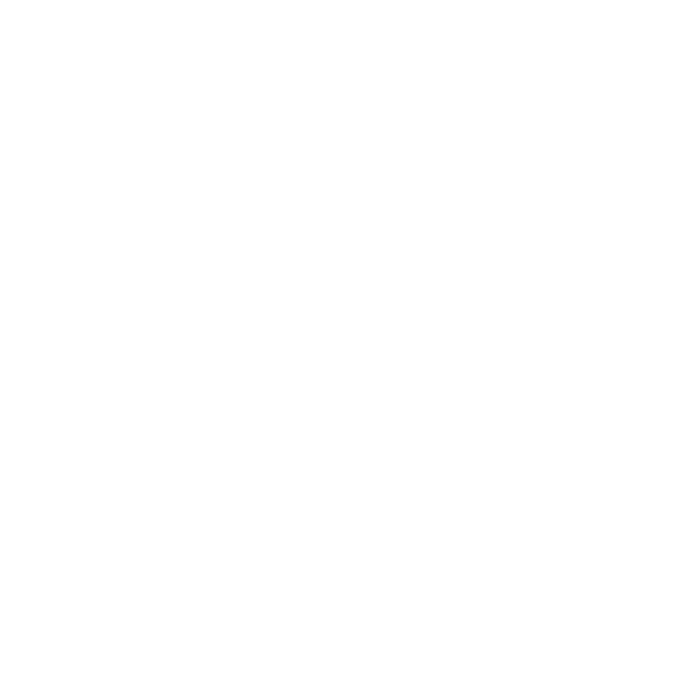

In [15]:
# To run and final ineteraction
euro = leaf.Map(center = (63.6252978589571, 5.24580993652344),
             zoom = 3,
             layout=ipyw.Layout(width='30%', height='550px',lenght='350px'))

geo_data = leaf.GeoData(geo_dataframe=euro2,
                   style={'color': 'white', 'fillColor': 'blue', 'opacity':0.6, 'weight':4.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

geo_data.on_click(when_clicked_update_figure)

euro.add_layer(geo_data)


ipyw.HBox([euro ,fig_data.canvas], layout=ipyw.Layout(flex='2 2', width='100%'))
